# Sensitivity Analysis on Critical Policy variables

### Description
This notebook performs sensitivity analysis (SA) over 6 critical Policy variables. The analysis is done under the symptom based TTI with Strigency level 3.

### Motivation
The motivation behind this experiment is to simply check all the interactions of the main variables affecting R from policy configurations. These are almost all the variales controlling how people can affect R, rather than the virus, i.e. we don't look at infectious profile or asymptomatic percentage which are virus dependent. Ideally, we would expect some higher order interaction between WFH and probability of "Met before work". Perhaps, the smaller the WFH prob and the smaller Met before work prob the higher R would become.

### Notes
S3 is chosen simply because it is the mid-severtity set up of configurations on how to track and quarantine people. However,  strigency level really does not matter here, since we are varying WFH and go to school probabilities,  variables that basically control the Strigency levels themselves.




In [1]:
import os
import numpy as np
import pandas as pd
from   tqdm.notebook import trange
from   tti_explorer import config, utils
from   tti_explorer.case import simulate_case, CaseFactors
from   tti_explorer.contacts import EmpiricalContactsSimulator
from   tti_explorer.strategies import TTIFlowModel, RETURN_KEYS
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

from   matplotlib import colors as mcolors
from   matplotlib import cm
import numpy as np
import GPy
from   emukit.core import ContinuousParameter, ParameterSpace

from emukit_new.sensitivity.monte_carlo import ModelFreeMonteCarloSensitivity
from emukit_new.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit_new.sensitivity.monte_carlo import MonteCarloSecondOrderSensitivity

from   emukit.core.initial_designs import RandomDesign
from   GPy.models import GPRegression
from   emukit.model_wrappers import GPyModelWrapper

from   emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from   emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
import matplotlib.pyplot as plt
import teaching_plots as plot
import mlai
import pandas as pd
from   tti_explorer.strategies import TTIFlowModel

#SALib Sobol
from SALib.sample import saltelli
from SALib.analyze import sobol
import time 


def print_doc(func):
    print(func.__doc__)
rng = np.random.RandomState(0)

def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")
path_to_bbc_data = os.path.join("../../data", "bbc-pandemic")



In [23]:
def update_policy_config_for_bo(go_to_school_prob, met_before_w, met_before_s, met_before_o, wfh_prob, app_cov):
    policy_config['go_to_school_prob'] = go_to_school_prob
    policy_config['met_before_w'] = met_before_w
    policy_config['met_before_s'] = met_before_s
    policy_config['met_before_o']  = met_before_o
    policy_config['wfh_prob']=wfh_prob
    policy_config['app_cov']=app_cov
    
#     contacts_config['asymp_factor']=asym_factor


    policy_config['compliance']=0.75


    return policy_config

In [24]:


def run_tti_sim(pol_configs):
    to_return=[]
    for vals in pol_configs:
        policy_config = update_policy_config_for_bo(vals[0], vals[1],vals[2], vals[3],vals[4], vals[5])
        factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
        strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
        rng = np.random.RandomState(42)
        tti_model = TTIFlowModel(rng, **strategy_config)
        n_cases = 10000
        outputs = list()
        temp =[]
        for _ in trange(n_cases):
            case = simulate_case(rng, **case_config)
            case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
            contacts = simulate_contacts(case, **contacts_config)
            res = tti_model(case, contacts, case_factors)
            outputs.append(res)
            if res["Effective R"] >= 0:
                temp.append(res["Effective R"]) # Get effective R. Only non-nan vals are kept
        to_return.append(np.mean(temp))
    return np.expand_dims(np.array(to_return), 1)


In [89]:
v1 = [0.00, .99]
v2 = [0.05,.99]
v3 = [0.05, .99]
v4 = [0.05, .99]
v5 = [0.05, .75]
v6 = [0.05, .7]
v7 = [0.05, .99]



def run_sensitivity(strigency, initial_samples, bo_samples, mc_samples, col):

    space = ParameterSpace([ContinuousParameter('go_to_school_prob', *v1),
        ContinuousParameter('met_before_w', *v2),
        ContinuousParameter('met_before_s', *v3),
            ContinuousParameter('met_before_o', *v4),
                ContinuousParameter('wfh_prob', *v5),
                           ContinuousParameter('app_cov', *v7)]) # init param space for experimental design
    design = RandomDesign(space)
    x = design.get_samples(initial_samples) # get 5 random combinations of initialisations
    y = run_tti_sim(x) # obtain corresponding effective_rs

    # Fitting emulator to data, x: (app_cov, compliance), y: effective_r
    kern_eq = GPy.kern.StdPeriodic(input_dim=6, period =[2,2,2,2,2,2], lengthscale=[2,2,2,2,2,2], ARD1 = True, ARD2=True)*GPy.kern.RBF(input_dim=6,lengthscale=[2,2,2,2,2,2], ARD=True) + GPy.kern.White(input_dim=6, variance=2**2)

    kern_bias = GPy.kern.Bias(input_dim=6)
#     kern = kern_eq + kern_bias
    model_gpy = GPRegression(x,y, kern_eq)
    model_gpy.kern.variance = 2**2
    # model_gpy.likelihood.variance.fix(1e-5)
    model_emukit = GPyModelWrapper(model_gpy)
    model_emukit.optimize() # optimise (max log-lik)

    # Initialise experimental design loop. Using integrated variance as acquisition
    # to "query" the input space aiming to reduce uncertainty over the func we're approx. i.e. effective_r
    num_of_loops = bo_samples
    integrated_variance = IntegratedVarianceReduction(space=space, model=model_emukit)
    ed = ExperimentalDesignLoop(space=space, model=model_emukit, acquisition = integrated_variance)
    ed.run_loop(run_tti_sim, num_of_loops)
    # Plot Main Effects
    num_mc = mc_samples
    senstivity = MonteCarloSecondOrderSensitivity(model = model_emukit, input_domain = space)
    main_effects_gp, secondary_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = mc_samples)
    print("main_effects: ", main_effects_gp)
    print("total_effects: ", total_effects_gp)
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
    main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

    d = {'App Uptake - Compliance Sensitivity Analysis':main_effects_gp_plot}

    pd.DataFrame(d).plot(kind='bar', ax=ax, color=col, alpha=0.65)
    plt.ylabel('% of explained output variance')
    out_name = "main-effects-strig-{}.pdf".format(strigency)

#     mlai.write_figure(filename=out_name, directory='./uq')

    # Plot Total Effects
    fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
    total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}
    d = {'App Uptake - Compliance Sensitivity Analysis':total_effects_gp_plot}
    pd.DataFrame(d).plot(kind='bar', ax=ax, color=col, alpha=0.65)
    ax.set_ylabel('% of explained output variance')
    out_name = "total-effects-strig-{}.pdf".format(strigency)
#     mlai.write_figure(filename=out_name, directory='./uq')

    
    #SALib

    param = [' GS ',' MBW ', ' MBS ',  '  MBO ', ' WFO ', ' AU']

    problem = {
        'num_vars': 6,
        'names': param,
        'bounds': [v1,v2,v3,v4,v5,v7]
    }
    
    
    xt = saltelli.sample(problem, mc_samples)
    Y,_= model_gpy.predict(xt)
    Y = np.squeeze(Y)
    Si = sobol.analyze(problem, Y)
    
    
    
    first_lim  = [0, 0.95]
    second_lim = [0, 0.95]
    total_lim  = [0, 0.95]
    param2 = []

    fig, ax = plt.subplots(2, 2, figsize=plot.big_wide_figsize)
    fig.subplots_adjust(hspace=0.5)


    ax[0][0].set_title("1st Order Sobol (SALab)")
    for index,val in enumerate(Si['S1']):
        ax[0][0].bar(param[index],val, color = col)
    ax[0][0].set_ylim(first_lim)

#     ax[0][1].set_title("2nd Order Sobol (SALab)")
#     for i in range(len(param)):
#         for j in range(len(param)):
#             val =  Si['S2'][i][j]
#             if val > -0.5:
#                 name = param[i] + '+'+ param[j]
#                 ax[0][1].bar(name, Si['S2'][i][j], color = col)
#                 param2.append(name)
#     ax[0][1].set_ylim(first_lim)

    ax[0][1].set_title("Total Effect Sobol (SALab)")
    for index,val in enumerate(Si['ST']):
        ax[0][1].bar(param[index],val, color = col)
    ax[0][1].set_ylim(total_lim)

    ax[1][0].set_title("1st Order Sobol (Emukit)")
    for index, ivar in enumerate(main_effects_gp):
        ax[1][0].bar(param[index], main_effects_gp[ivar][0], color = col)
    ax[1][0].set_ylim(first_lim)


#     ax[1][1].set_title("2nd Order Sobol (Emukit)")
#     for index, ivar in enumerate(secondary_effects_gp):
#         ax[1][1].bar(param2[index], secondary_effects_gp[ivar][0], color = col)
#     ax[1][1].set_ylim(first_lim)


    ax[1][1].set_title("Total Effect Sobol (Emukit)")
    for index, ivar in enumerate(total_effects_gp):
        ax[1][1].bar(param[index], total_effects_gp[ivar][0], color = col)
    ax[1][1].set_ylim(total_lim)


    # ax[0][1].set_title('Sensitivity Analysis on Policy Configurations Without Experimental Design Loop')
    ax[0][0].set_ylabel('% of explained output variance')
    ax[1][0].set_ylabel('% of explained output variance')
#     ax[1][1].set_xlabel('GS = Go to school; MBW = Work; MBS: School; MBO: Other; WFH: Work from home; AU; App usage')
#     ax[1][0].set_xlabel('GS = Go to school; MBW = Work; MBS: School; MBO: Other; WFH: Work from home; AU; App usage')



#         param = [' GS ',' MBW ', ' MBS ',  '  MBO ', ' WFH ', ' AU ', ' AS']



    plt.tight_layout()
#     plt.show()
    out_name = "sa-vars-SA-{}.pdf".format(strigency)

    plt.savefig(out_name, format='pdf', bbox_inches='tight')





Optimization restart 1/1, f = -132.21863626443314
Optimization restart 1/1, f = -132.21863644879755


 /usr/local/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


main_effects:  {'go_to_school_prob': array([0.14077412]), 'met_before_w': array([-0.00727491]), 'met_before_s': array([-0.02317196]), 'met_before_o': array([-0.01470509]), 'wfh_prob': array([0.68867674]), 'app_cov': array([0.09559563])}
total_effects:  {'go_to_school_prob': array([0.15836354]), 'met_before_w': array([0.08057167]), 'met_before_s': array([0.05546706]), 'met_before_o': array([0.06615858]), 'wfh_prob': array([0.77195095]), 'app_cov': array([0.17145367])}


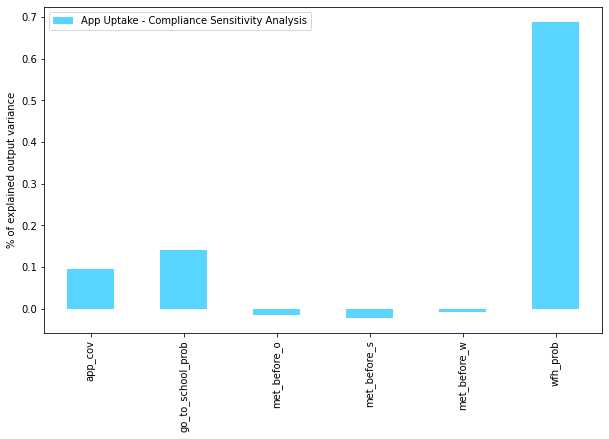

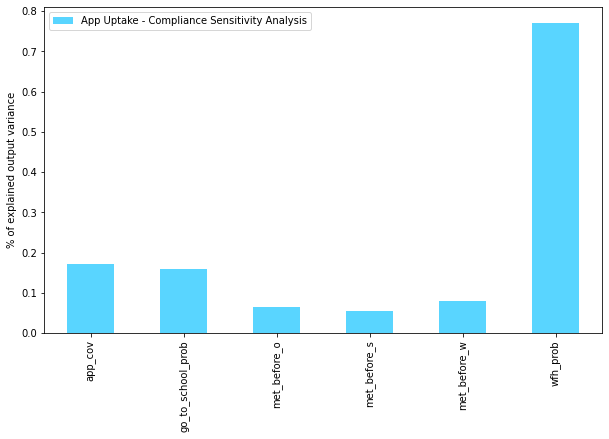

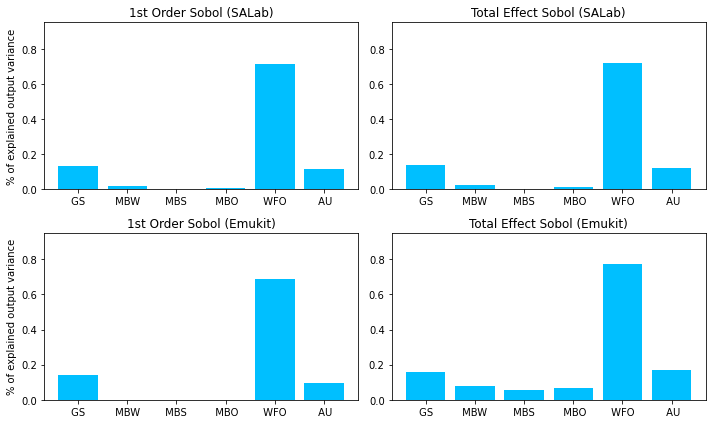

In [91]:
strigency = "S3_symptom_based_TTI"
over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
cidx=3
cols = ['red', 'tomato', 'orange', 'deepskyblue', 'green']

case_config = config.get_case_config("delve")
contacts_config = config.get_contacts_config("delve")
policy_config = config.get_strategy_configs("delve", strigency)[strigency]
factor_config = utils.get_sub_dictionary(policy_config, config.DELVE_CASE_FACTOR_KEYS)
strategy_config = utils.get_sub_dictionary(policy_config, config.DELVE_STRATEGY_FACTOR_KEYS)
rng = np.random.RandomState(42)

tti_model = TTIFlowModel(rng, **strategy_config)

run_sensitivity(strigency, 50, 5, 100000, cols[cidx])
